In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing


In [2]:
pd.set_option('display.max_columns',None)
sns.set(style='darkgrid',palette='deep',font_scale=1.1,rc={'figure.figsize':[20,10]})

In [3]:
survey = pd.read_csv('csvs/survey_responses_training.csv')
voter_info = pd.read_csv('csvs/voter_information_training.csv')
voter_hist = pd.read_csv('csvs/voting_history_training.csv')

In [155]:
survey.head()

,myv_van_id,contact_type_name,datetime_canvassed,master_survey_question_name,master_survey_response_name
0,3727336,Phone,2016-10-31 00:00:00 UTC,**MSQ2016 Ticket,1 - Strong Support
1,3596564,Phone,2016-10-21 00:00:00 UTC,**MSQ2016 Ticket,1 - Strong Support
2,3460754,Phone,2016-10-11 00:00:00 UTC,**16cccRecVBMApp,"No, Not Received"
3,3489299,Phone,2018-07-28 00:00:00 UTC,MSQ2018: VOL DCCC,2= No
4,4186850,Phone,2018-06-16 00:00:00 UTC,MSQ2018:CONG ID DCCC,5 - Support GOP


In [156]:
voter_info.head()

,myv_van_id,age_combined,gender_combined,ethnicity_combined,zip,registration_date,van_precinct_name,state_house_district_latest,state_senate_district_latest,us_cong_district_latest
0,37835355,24,U,B,75228,2015-11-05,1065,100,23,30
1,40915631,26,U,NaN,75150,2018-11-06,1300,107,2,5
2,40802481,47,U,NaN,75043,2018-10-20,1722,113,2,32
3,38944227,56,U,B,75041,2016-11-08,1729,113,2,32
4,4055165,62,U,B,75081,2000-11-02,2514,102,8,32


In [157]:
voter_hist.head()

,Unnamed: 0,myv_van_id,party_id,election_date
0,0,4244191,1.0,2016-05-24
1,1,3719754,2.0,2016-05-24
2,2,3576807,1.0,2016-05-24
3,3,4096169,1.0,2016-05-24
4,4,3475084,2.0,2016-05-24


In [158]:
print(len(voter_hist['myv_van_id'].unique()))

voter_hist['voted'] = np.where(voter_hist['election_date'] == '2018-11-06',1,0)
voter_hist['voted'].value_counts()

7261


0    27940
1     5490
Name: voted, dtype: int64

In [159]:
print('\n\n Data Types \n')
print(f'1. survey d-types:\n {survey.dtypes}\n\n')
print(f'2. voter_information d-types:\n {voter_info.dtypes}\n\n')
print(f'3. voter_history d-types:\n {voter_hist.dtypes}')



 Data Types 

1. survey d-types:
 myv_van_id                      int64
contact_type_name              object
datetime_canvassed             object
master_survey_question_name    object
master_survey_response_name    object
dtype: object


2. voter_information d-types:
 myv_van_id                       int64
age_combined                     int64
gender_combined                 object
ethnicity_combined              object
zip                              int64
registration_date               object
van_precinct_name                int64
state_house_district_latest      int64
state_senate_district_latest     int64
us_cong_district_latest          int64
dtype: object


3. voter_history d-types:
 Unnamed: 0         int64
myv_van_id         int64
party_id         float64
election_date     object
voted              int64
dtype: object


# an agenda; a forethought:

#### 1A. Join voter_info and survey_respones, keep voter_history separate. 
    - lets use these 2 merged df's to generate some numeric variables.
    - this is looking entirely categorical so far. joining all 3 will make isolating target variable hard.

#### 1B. Check for missing_values 
    - probably not many because this is VAN.

#### 2. "master_survey_respone_name" --> try to group it / make useful
    - lot of messiness here / redundancy

#### 3. feature-engineering = i want to see a numerical abs(date_registered - election day 2018
    - get an average amount of days from OG registration to Election Day 2018.
    - this at least will correlate to the target variable (did they vote?) 
    - and their voting history (% of elections voted in)
    - could be cool


#### 4. see relationships with seaborn
     - let's use groupby with sns.heatmap / pivot_table to check.
     - to see how locations play in with gender, party, etc. later on...
     - precints, districts, etc. will have redundancy. 
     - what is a good balance to distribute as a categorical variable but not be too sparse?
     - maybe ethnicity aint useful


#### 5. one-hot-encode categoricals (this is why we are trying to limit features AMAP)

#### 6. Quick n dirty Random Forest to verify important features

#### 7. GridsearchCV for best params across Logreg, GradboostDT, RandoForest 
    - why? 
    - logreg is an important baseline. we are doing basic classification. always good to start small. 
    - Gradboostdt is very robust against over-fitting, and is a great "out of the box" classifier
    - random forest, tho higher computational cost, like gradboost, does deliver us feature_importances_

## 1A. merge survey_responses.csv + voter_information.csv

In [160]:
df = pd.merge(survey,voter_info,how='outer',on='myv_van_id')
df.head()

,myv_van_id,contact_type_name,datetime_canvassed,master_survey_question_name,master_survey_response_name,age_combined,gender_combined,ethnicity_combined,zip,registration_date,van_precinct_name,state_house_district_latest,state_senate_district_latest,us_cong_district_latest
0,3727336,Phone,2016-10-31 00:00:00 UTC,**MSQ2016 Ticket,1 - Strong Support,68,F,W,75224,1992-09-20,4046,111,23,33
1,3596564,Phone,2016-10-21 00:00:00 UTC,**MSQ2016 Ticket,1 - Strong Support,93,F,H,75228,1993-05-20,1058,100,2,5
2,3596564,Phone,2016-10-21 00:00:00 UTC,MSQ2016 POTUS,1 - Support Dem,93,F,H,75228,1993-05-20,1058,100,2,5
3,3460754,Phone,2016-10-11 00:00:00 UTC,**16cccRecVBMApp,"No, Not Received",67,M,W,75228,1988-11-08,1058,100,2,5
4,3460754,SMS Text,2018-11-06 12:34:00 UTC,2018MSQ: Erly Vt Cmt,Election Day,67,M,W,75228,1988-11-08,1058,100,2,5


In [161]:
df.shape

(16782, 14)

In [162]:
len(df.us_cong_district_latest.unique())

6

In [163]:
len(df.state_house_district_latest.unique())

14

In [164]:
len(df.zip.unique())

90

In [165]:
#### just checking...

## 1B. missing?

In [166]:
missing_val = df.isnull().sum()
miss_val_percent = 100* df.isnull().sum() / len(df)
missing_df = pd.concat([missing_val,miss_val_percent],axis=1)
missing_df.columns = ['missing_val','miss_val_%']
missing_df = missing_df[missing_df.iloc[:,0] != 0].sort_values('missing_val',ascending=False)
missing_df

,missing_val,miss_val_%
master_survey_response_name,7649,45.578596
contact_type_name,6594,39.292099
datetime_canvassed,6594,39.292099
master_survey_question_name,6594,39.292099
ethnicity_combined,811,4.832559


#### Kind of a bummer. 
- Really wanted to use "master_survey_response_name", but 45% missing values is a bit steep. 
- i'll perform the cleaning on it that i wanted and see about adding it in. 

## 2. Survey_Responses

In [167]:
survey['master_survey_question_name'].unique()

array(['**MSQ2016 Ticket', '**16cccRecVBMApp', 'MSQ2018: VOL DCCC',
       'MSQ2018:CONG ID DCCC', '2018MSQ: Erly Vt Cmt',
       'MSQ2018: Pri-ID DCCC', 'MSQ2016 Vote Plan',
       '2018MSQ: D Ticket ID', 'MSQ2016 State House',
       '15 MSQ: Generic ID', 'MSQ: Support Beto', '**SubVBMBallot',
       '2018MSQ: CandidNomin', 'MSQ2016 POTUS', '2014MSQ: Ticket',
       'MSQ2016 Party ID', 'MSQ2016 Volunteer', 'MSQ2016 Commissioner',
       'MSQ2016 Yard Sign', 'MSQ2018: VOTE PLAN', '17-18 Volunteer Ask',
       'MSQ2018: PET DCCC', '2014MSQ: Downballot'], dtype=object)

In [168]:
#useless

In [169]:
survey['master_survey_response_name'].unique()

array(['1 - Strong Support', 'No, Not Received', '2= No',
       '5 - Support GOP', 'Mail', '2-Undecided', 'Early Vote',
       'T- Ticket Splitter', '1 - Strong Democrat', 'i- Independent',
       '1= Yes', '5 - Strong Cruz', 'Not Voting', '2 - Lean Democrat',
       '2 - Lean Dem', '4 - Lean GOP', 'No, In Person',
       'd- 1—Splitter moreDs', 'Voting in Person', '5 - Strong Against',
       '4-No Support Rep', 'Yes, Received', '3-No Other Dem',
       'T - Ticket Splitter', 'Ticket Splitter', '3 - Neither/Unsure',
       'Maybe/Depends', '5-Strong Republican', 'Yes - Requested',
       'No Will Not', nan, 'No', 'Yes', '1-Yes', 'Maybe', '3- Undecided',
       'Election Day', '3 - Undecided', 'Already Voted', 'Yes, Plan Made',
       '1 - Support Dem', '2- Lean Democrat', '1- Strong Democrat',
       '4- Lean Republican', '5- Strong Republican',
       'P- OthrPrimaryCntact'], dtype=object)

In [170]:
#useful?

#### Group responses

In [171]:
def survey_response(x):
    
    repub = {'republican':['5','4','rep']}
    dem = {'democrat':['1','dem','lean democrat']}
    undec = {'undecided':['ticket','3','undecided','maybe']}
    no = {'not_voting':['no']}
    responses = [repub,dem,undec,no]
    
    for response in responses:
        for k,v in response.items():
            for z in v:
                if str(z) in str(x).lower():
                    return k

df['master_survey_response_name'] = df['master_survey_response_name'].apply(survey_response)            

In [172]:
df['master_survey_response_name'].value_counts()

democrat      5518
undecided      897
republican     742
not_voting     262
Name: master_survey_response_name, dtype: int64

In [173]:
df.drop(columns='master_survey_question_name',axis=1,inplace=True)

# rename it for easier use.
df = df.rename(columns={'master_survey_response_name':'survey'})

## 3. Feature Engineering

#### on abs(Dates)...

In [174]:
df['eday'] = '2018-11-06'

df['registration_date'] = pd.to_datetime(df['registration_date']).dt.date
df['eday'] = pd.to_datetime(df['eday']).dt.date


# get days since, normalize by years. note: same day registration = 0
df['vote_since_register'] = (df['eday'] - df['registration_date'])
df['vote_since_register'] = df['vote_since_register'].apply(lambda x: round(int(x.days) / 365,1))

# check distribution
df['vote_since_register'].value_counts()

42.6    533
2.0     479
0.0     419
10.0    335
6.0     325
       ... 
29.2      1
33.2      1
37.7      1
39.3      1
28.4      1
Name: vote_since_register, Length: 411, dtype: int64

#### on % Of Elections Voted in...

In [175]:
elecs = len(voter_hist['election_date'].unique())
gb = voter_hist.groupby('myv_van_id')['election_date']
voter_gb_van_id = (gb.count()).apply(lambda x: round(100* x/elecs,2))

####  lock-in our 'Voted' Target variable while we're here

In [176]:
history_gb_elections = pd.DataFrame(voter_gb_van_id).reset_index().rename(columns={'election_date':'% election'})
df2 = pd.merge(history_gb_elections,voter_hist,how='inner',on='myv_van_id')
df2 = df2.drop(columns=['Unnamed: 0','party_id','election_date'])
df3 = pd.pivot_table(data=df2,index='myv_van_id')
df3['voted'] = np.where(df3['voted'] > 0,1,0)
df3.head()

,% election,voted
myv_van_id,,
1905,34.78,1
7509,43.48,1
10993,21.74,1
22643,4.35,0
25108,52.17,1


In [177]:
len(df3)

7261

## Re-Cap: we have:
    - engineered abs(registration - e-day 2018) feature
    - engineered % of elections voted in by Van_id
    - added a 1 for 'voted' and 0 for those that didnt' vote in 2018 election, and removed redundant Van_ids
    - grouped some survey responses and made another column with 1/0 for them sounding like a voter at door/phone
## What's Left? 
    - find a location metric to use that won't be too sparse but also not too boring.
    - merge df + df3 on inner Van_id, so that we have only one unique Van_id, but all our features for them
    - Features:
        1. Gender                     - Categorical (tri-variate; ok for sparse matrix)
        2. Age                        - Numeric
        3. Voted?                     - (Target)             
        4. % Of Elections voted in    - Numeric
        5. abs(registration-eday)     - Numeric
        6. Congressional_district     - Categorical (six-variate; ok for sparse matrix)
        7. Ethnicity                  - Categorical (pent-variate; pending removal of NaN)
        8. Survey                     - this will be tough on inner merge... i wonder how it will look.

In [178]:
df.head()

,myv_van_id,contact_type_name,datetime_canvassed,survey,age_combined,gender_combined,ethnicity_combined,zip,registration_date,van_precinct_name,state_house_district_latest,state_senate_district_latest,us_cong_district_latest,eday,vote_since_register
0,3727336,Phone,2016-10-31 00:00:00 UTC,democrat,68,F,W,75224,1992-09-20,4046,111,23,33,2018-11-06,26.1
1,3596564,Phone,2016-10-21 00:00:00 UTC,democrat,93,F,H,75228,1993-05-20,1058,100,2,5,2018-11-06,25.5
2,3596564,Phone,2016-10-21 00:00:00 UTC,democrat,93,F,H,75228,1993-05-20,1058,100,2,5,2018-11-06,25.5
3,3460754,Phone,2016-10-11 00:00:00 UTC,not_voting,67,M,W,75228,1988-11-08,1058,100,2,5,2018-11-06,30.0
4,3460754,SMS Text,2018-11-06 12:34:00 UTC,None,67,M,W,75228,1988-11-08,1058,100,2,5,2018-11-06,30.0


In [179]:
df = df.drop(columns=['datetime_canvassed','contact_type_name','registration_date','van_precinct_name','eday'])

In [180]:
col_renames = {'age_combined':'age',
             'gender_combined':'gender',
             'ethnicity_combined':'ethnicity',
             'state_house_district_latest':'state_house',
             'state_senate_district_latest':'state_senate',
             'vote_since_register':'yrs_reg',
             'us_cong_district_latest':'CD'}
df = df.rename(columns=col_renames)

In [181]:
df.head()

,myv_van_id,survey,age,gender,ethnicity,zip,state_house,state_senate,CD,yrs_reg
0,3727336,democrat,68,F,W,75224,111,23,33,26.1
1,3596564,democrat,93,F,H,75228,100,2,5,25.5
2,3596564,democrat,93,F,H,75228,100,2,5,25.5
3,3460754,not_voting,67,M,W,75228,100,2,5,30.0
4,3460754,None,67,M,W,75228,100,2,5,30.0


In [182]:
df3.head()

,% election,voted
myv_van_id,,
1905,34.78,1
7509,43.48,1
10993,21.74,1
22643,4.35,0
25108,52.17,1


In [183]:
training = pd.merge(df3,df,on='myv_van_id',how='inner')

In [184]:
training = training.drop_duplicates(subset='myv_van_id')

In [185]:
training = training[training['gender'].isin(['M','F'])]

In [186]:
training.survey.value_counts()

democrat      814
republican    348
undecided     330
not_voting    152
Name: survey, dtype: int64

In [188]:
training.head()

,myv_van_id,% election,voted,survey,age,gender,ethnicity,zip,state_house,state_senate,CD,yrs_reg
0,1905,34.78,1,None,57,F,W,75048,112,8,32,10.0
1,7509,43.48,1,republican,59,M,W,75204,108,16,32,11.3
3,10993,21.74,1,None,48,M,B,75227,110,23,30,6.0
4,22643,4.35,0,republican,65,M,W,75220,114,16,24,2.6
5,25108,52.17,1,None,86,F,W,75089,112,16,32,1.0


### The majority of voters is < 10 years registered, almost perfect linear relationship to age and yrs_reg... not super interesting

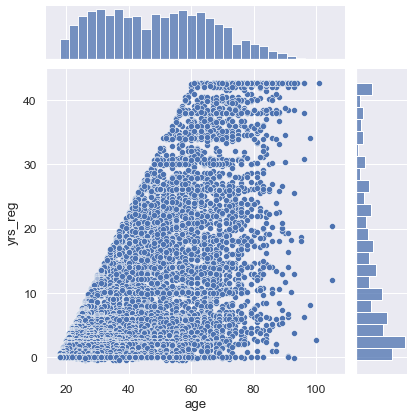

In [189]:
sns.jointplot(x = training.age,y = training.yrs_reg);

### Adding in the "hue" feature of the sns.lmplot, i see a lot of nested results. this shows me the geometry of the results might be worth playing with. I transformd the numeric data by log and sqrt to see if the visual changed. it didn't really. just wanted to check!

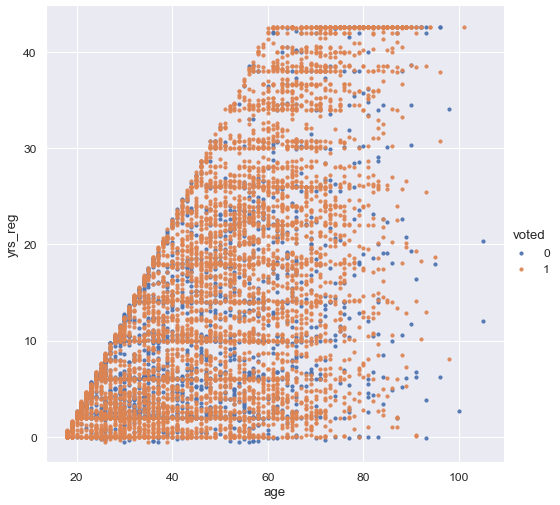

In [190]:
sns.lmplot(x='age',y='yrs_reg',hue='voted',data=training,fit_reg=False,scatter_kws={'alpha':0.9,'s':10},height=7,aspect=1);

#### Keep it simple with categorical hists and bars. Our numeric aren't that profound, yet they might be in our Classifier.

### Women voted ~.25 more times than men on eday 11-06-18

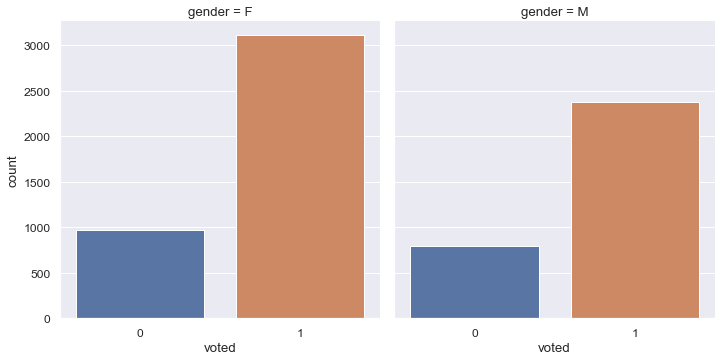

In [37]:
sns.catplot(x='voted',col='gender',kind='count',data=training);

### Some good variance here in ethnicity. could really help our our classifier.

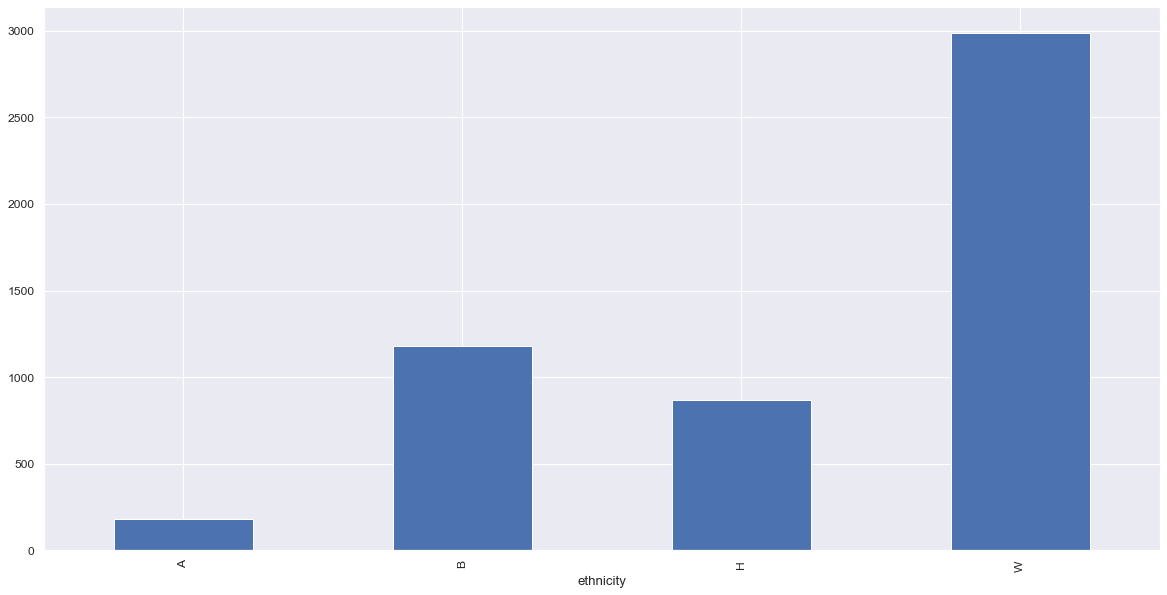

In [38]:
training.groupby('ethnicity')['voted'].sum().plot.bar();

### Besides CD 26 which offers almost no results, this heatmap shows that ethnicity and CD together provide some interesting information. There is variety and different 'temps' across CDs, across ethnicity.

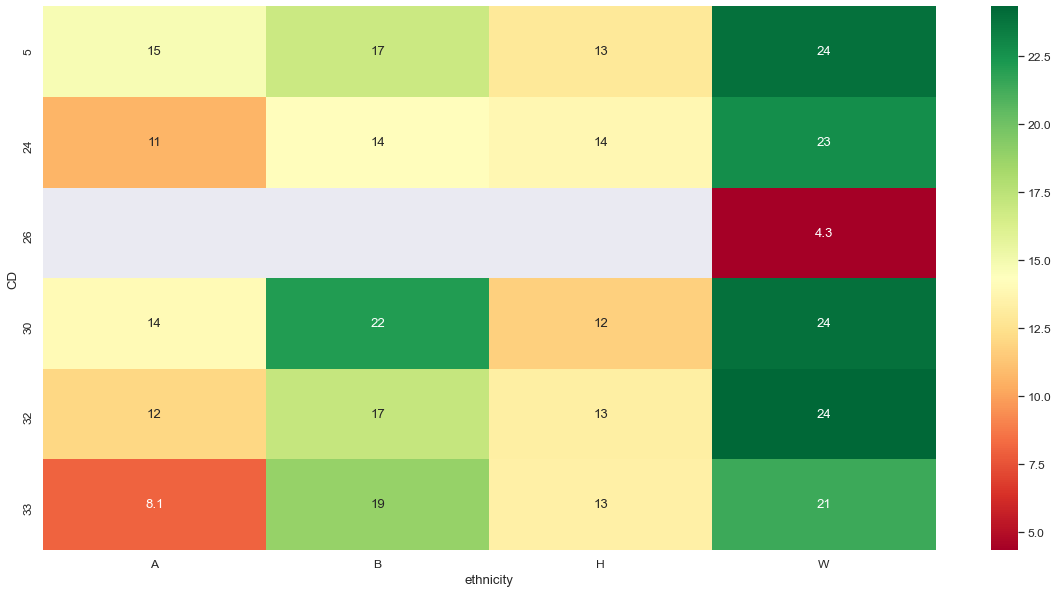

In [105]:
result = pd.pivot_table(data=training,index='CD',columns='ethnicity',values='% election')
sns.heatmap(result,annot=True,cmap='RdYlGn');

In [106]:
result

ethnicity,A,B,H,W
CD,,,,
5,14.746522,16.905824,12.875667,23.917249
24,10.622911,14.230505,13.859687,22.775904
26,NaN,NaN,NaN,4.350000
30,13.975357,22.112755,11.714941,23.917208
32,12.073495,17.136261,13.261041,24.339898
33,8.076429,18.841429,13.389801,21.382802


# 5. One-hot-encoding of Categoricals. make some choices quickly. 

In [109]:
training = training.drop(['survey','zip','state_house','state_senate','voted_response'],axis=1)

In [110]:
training.head()

,myv_van_id,% election,voted,age,gender,ethnicity,CD,yrs_reg
0,1905,34.78,1,57,F,W,32,10.0
1,7509,43.48,1,59,M,W,32,11.3
3,10993,21.74,1,48,M,B,30,6.0
4,22643,4.35,0,65,M,W,24,2.6
5,25108,52.17,1,86,F,W,32,1.0


In [111]:
training_encoded = pd.get_dummies(training,columns=['CD','gender','ethnicity','CD']).set_index('myv_van_id')

# 6. Random Forest Quick n Dirty to see Feature_Importances_

In [118]:
y = training_encoded.voted.dropna(how='all')
X = training_encoded.drop(columns='voted').dropna(how='all')

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=47)

In [124]:
clf = RandomForestClassifier(max_depth=2, n_estimators=1000, random_state=47)
clf.fit(X_train,y_train)
y_pred_prob = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.8013253119213384

## Feature_Importances_

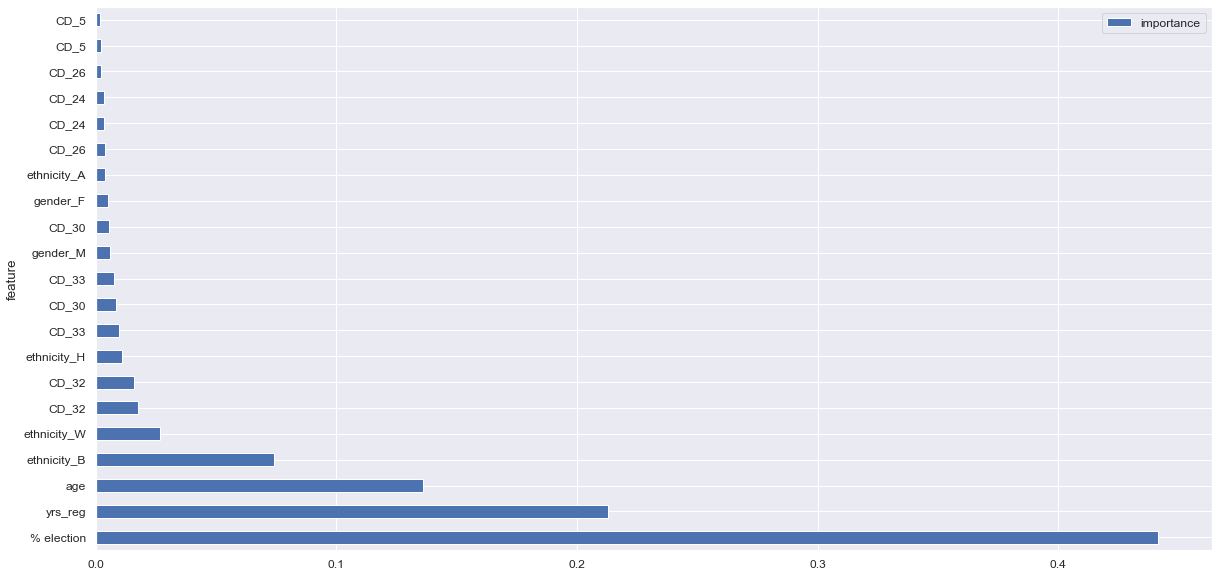

In [130]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':clf.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.barh();

# 7. GridSearchCV, train Gradient Boost Decision Tree & Logistic Regression
    - logr = (really good baseline, simple tuning, perfect for classification of this kind.)
    - gbdt = (best out of the box, has worked well for me in the past, prevents overfitting)
    - i chose not to go with a kernelized (polynomial, rbf) SVM because the geometry of my numerical data wasnt         super crazy. i checked it with log/sqrt transformations too. 

In [145]:
from sklearn import preprocessing

param_grid_log = {'C':[1.5,2.5,3.5,4],'max_iter':[1000,10000],'penalty':['l2']}
param_grid_gb = {'n_estimators':[1000,5000,10000],'learning_rate':[.01,.1,.5],'max_depth':[2,3,4]}
#param_grid_rf = {'n_estimators':[1000,5000,10000],'max_depth':[2,3,4,5]}

logr = LogisticRegression()
gb = GradientBoostingClassifier()
# rf = RandomForestClassifier()

param_grids = [param_grid_log,param_grid_gb]
clfs = [logr,gb]


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

for clf, param_grid in zip(clfs,param_grids):
    grid_clf_auc = GridSearchCV(clf, param_grid = param_grid, scoring = 'roc_auc' )
    grid_clf_auc.fit(X_train_scaled,y_train)
    print(f'for {clf} the best paramaters are {grid_clf_auc.best_params_}\n')
    print(f'for {clf} the best auc_score is {grid_clf_auc.best_score_}')
    
    


for LogisticRegression() the best paramaters are {'C': 4, 'max_iter': 1000, 'penalty': 'l2'}

for LogisticRegression() the best auc_score is 0.8495956707756891
for GradientBoostingClassifier() the best paramaters are {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}

for GradientBoostingClassifier() the best auc_score is 0.8747556306778737


#### If i had more time, i'd dive into the features, removing cloudy categoricals such as CD and see what other numericals i could create. the good news: the feature engineering i did paid off. those were my most important features according to the quick n' dirty Random Forest. 
- GBDT = .874 AUC
- logreg = .849 AUC

#### ideal parameters for GBDT = {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}
I will use GBDT due to its robustness to over-fitting. 